# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as PP

# magic word for producing visualizations in notebook
%matplotlib inline

sns.set()

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.

azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Azdias dataframe shape:", azdias.shape)
azdias.head()

Azdias dataframe shape: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print("Feature summary shape:", feat_info.shape)

feat_info.head(n=5)

Feature summary shape: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#List of columns
cols = list(azdias.columns)
cols;


In [6]:
#Warning: Column Dropped! RUN ONLY ONCE

feat_info = feat_info.set_axis(cols, axis='index')
feat_info.drop(["attribute"], axis=1, inplace = True)

#Adding a dtype column to keep track of types
feat_info['dtype'] = azdias.dtypes
feat_info

,information_level,type,missing_or_unknown,dtype
AGER_TYP,person,categorical,"[-1,0]",int64
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",int64
ANREDE_KZ,person,categorical,"[-1,0]",int64
CJT_GESAMTTYP,person,categorical,[0],float64
FINANZ_MINIMALIST,person,ordinal,[-1],int64
...,...,...,...,...
PLZ8_HHZ,macrocell_plz8,ordinal,[-1],float64
PLZ8_GBZ,macrocell_plz8,ordinal,[-1],float64
ARBEIT,community,ordinal,"[-1,9]",float64
ORTSGR_KLS9,community,ordinal,"[-1,0]",float64


In [7]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

In [8]:
#Columns with object type data
object_cols = feat_info[feat_info["dtype"] == np.dtype('object')].index.values
print(object_cols)

#Looking at what data types are stored in object type columns
print("\n")
PP.pprint({column:azdias[column].apply(type).unique() for column in object_cols})

['OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015']


{'CAMEO_DEUG_2015': array([<class 'float'>, <class 'str'>], dtype=object),
 'CAMEO_DEU_2015': array([<class 'float'>, <class 'str'>], dtype=object),
 'CAMEO_INTL_2015': array([<class 'float'>, <class 'str'>], dtype=object),
 'OST_WEST_KZ': array([<class 'float'>, <class 'str'>], dtype=object)}


In [9]:
#Warning: COLUMN MODIFIED! RUN THIS CELL EXACTLY ONCE

def correct_type(x, datatype):
    if datatype!=np.dtype('object'):
        if x.lstrip('-').isdigit():
            #print("Numeric type")
            if datatype==np.dtype('int64'):
                #print("Integer type")
                return int(x)
            else:
                #print("Float type")
                return float(x)
    else:
        #print("String type")
        if x.lstrip('-').isdigit():
            return float(x)
        else:
            return x
        
#Creating another column 'm_or_u' to parse the 'missing_or_unknown' column. Good for debugging. Will drop later in this cell itself.

feat_info['m_or_u'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
feat_info['m_or_u'] = feat_info.apply(lambda row: [correct_type(y, row['dtype']) for y in row['m_or_u']], axis=1)

#Dropping the column 'm_or_u' and storing it in 'missing_or_unknown'
feat_info["missing_or_unknown"] = feat_info['m_or_u']
feat_info = feat_info.drop(["m_or_u"], axis=1)

In [10]:
#NAN replacement

for index in feat_info.index:
    azdias[index].replace(feat_info.loc[index, 'missing_or_unknown'], np.nan, inplace = True)

#Counting how many integer data columns got converted to float. This happened due to the nan replacement. 
#To be confirmed in the next cell

azdias.dtypes.value_counts()

float64    57
int64      24
object      4
dtype: int64

In [11]:
#Add a "nan" column to feat_info that counts how many missing/unknown values for each column
feat_info["nan"] = azdias.isna().sum()

#Checking how many columns have 0 missing values. Integer type columns with no missing data 

s2 = feat_info[feat_info["nan"]==0].index.values #columns with no missing values
print(f'Number of columns with no missing values after replacement: {len(s2)}')
print("\nFurthermore, these columns are:")
PP.pprint(s2)

s1 = feat_info[feat_info["dtype"]=='int64'].index.values
#s1 has columns that originally had integer data-type before replacement

#Checking if s2 is a subset of s1. If yes, 
if set(s2.tolist()).issubset(s1.tolist()):
    print("\nColumns with no missing values after replacement originally had integer data. \
          \nAs they have no missing values, they continue to have integer data type.")

Number of columns with no missing values after replacement: 24

Furthermore, these columns are:
array(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'],
      dtype=object)

Columns with no missing values after replacement originally had integer data.           
As they have no missing values, they continue to have integer data type.


In [12]:
feat_info["dtype"] = azdias.dtypes #Update data type in feat_info

In [13]:
#An overview of the data by type and digital datatype
grouped = feat_info.groupby(["type", "dtype"])
grouped.count()

information_level  missing_or_unknown  nan
type        dtype                                              
categorical int64                    4                   4    4
            float64                 14                  14   14
            object                   3                   3    3
interval    float64                  1                   1    1
mixed       float64                  6                   6    6
            object                   1                   1    1
numeric     float64                  7                   7    7
ordinal     int64                   20                  20   20
            float64                 29                  29   29

In [14]:
#Total number of missing values
azdias.isna().sum().sum()

8373929

In [15]:
#Avg number of missing values per column
azdias.isna().sum().sum()/azdias.shape[1]

98516.81176470588

In [16]:
#Avg number of missing values per row
azdias.isna().sum().sum()/azdias.shape[0]

9.396018495973502

In [17]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [18]:
feat_info

,information_level,type,missing_or_unknown,dtype,nan
AGER_TYP,person,categorical,"[-1, 0]",float64,685843
ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]",float64,2881
ANREDE_KZ,person,categorical,"[-1, 0]",int64,0
CJT_GESAMTTYP,person,categorical,[0.0],float64,4854
FINANZ_MINIMALIST,person,ordinal,[-1],int64,0
...,...,...,...,...,...
PLZ8_HHZ,macrocell_plz8,ordinal,[-1.0],float64,116515
PLZ8_GBZ,macrocell_plz8,ordinal,[-1.0],float64,116515
ARBEIT,community,ordinal,"[-1.0, 9.0]",float64,97375
ORTSGR_KLS9,community,ordinal,"[-1.0, 0.0]",float64,97274


**Missing data is either in a float64 column or an object datatype column!**

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

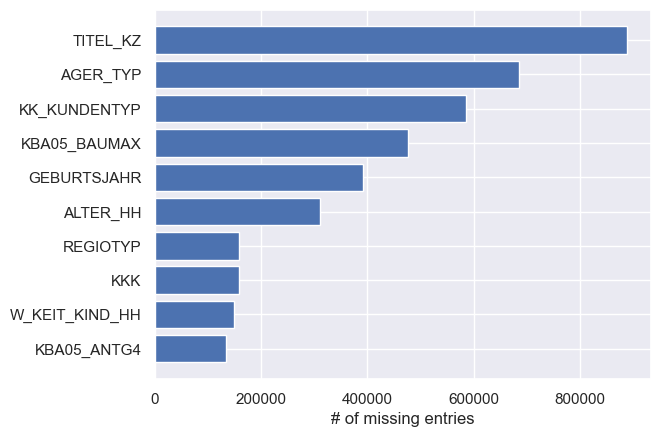

In [19]:
#BAR plot to see how many entries are missing in each column
sorted_feat = feat_info.sort_values(by=['nan']).tail(n=10)
plt.figure()
plt.barh(sorted_feat.index.values, [sorted_feat.loc[index, 'nan'] for index in sorted_feat.index.values])
plt.xlabel('# of missing entries')
#plt.ylabel('column name')
plt.show()

**It is quite clear that the top 6 columns are the outlier entries. We look at the histogram for distribution next.**

Using the histogram function below as an alternative method to find the outlier column(s).

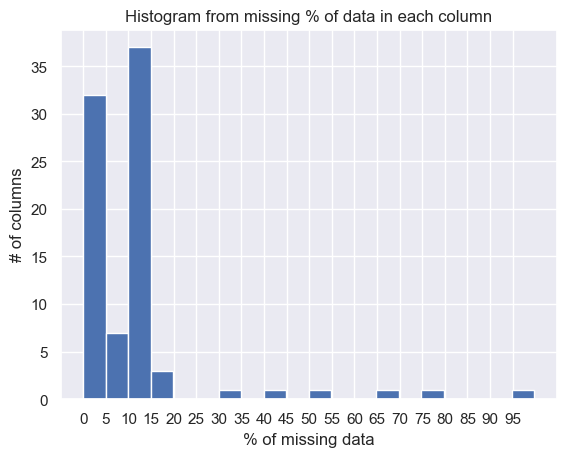

In [20]:
plt.hist(feat_info['nan']*100/len(azdias), bins = 20)
plt.title('Histogram from missing % of data in each column')
plt.xlabel("% of missing data")
plt.xticks(np.arange(0, 100, 5))
plt.ylabel("# of columns")
plt.show()

Beyond the 30% mark lie our outlier columns.

In [21]:
#Splitting the data into 10 bins with ~60000 missing entries in each histogram point, the function below tells the
# iloc of each column in a given bin x.

def arr_m(x):
    bins = [60000*x for x in np.arange(10)]
    indices = np.digitize(feat_info['nan'], bins)
    arr, = np.where(indices > x)
    return arr

#After some experimentation, our outlier columns lie in bin 3 onward
outlier_col_data = feat_info.iloc[arr_m(3), :]
outlier_col_data

,information_level,type,missing_or_unknown,dtype,nan
AGER_TYP,person,categorical,"[-1, 0]",float64,685843
GEBURTSJAHR,person,numeric,[0],float64,392318
TITEL_KZ,person,categorical,"[-1.0, 0.0]",float64,889061
ALTER_HH,household,interval,[0.0],float64,310267
KK_KUNDENTYP,household,categorical,[-1.0],float64,584612
KBA05_BAUMAX,microcell_rr3,mixed,"[-1.0, 0.0]",float64,476524


In [22]:
outlier_cols = outlier_col_data.index.values.tolist()
outlier_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [23]:
#Quick look at some columns missing more than 100k entries. Alternative way to find outlier data; Used for 
#cross-verification

feat_info[feat_info["nan"]>180000]

,information_level,type,missing_or_unknown,dtype,nan
AGER_TYP,person,categorical,"[-1, 0]",float64,685843
GEBURTSJAHR,person,numeric,[0],float64,392318
TITEL_KZ,person,categorical,"[-1.0, 0.0]",float64,889061
ALTER_HH,household,interval,[0.0],float64,310267
KK_KUNDENTYP,household,categorical,[-1.0],float64,584612
KBA05_BAUMAX,microcell_rr3,mixed,"[-1.0, 0.0]",float64,476524


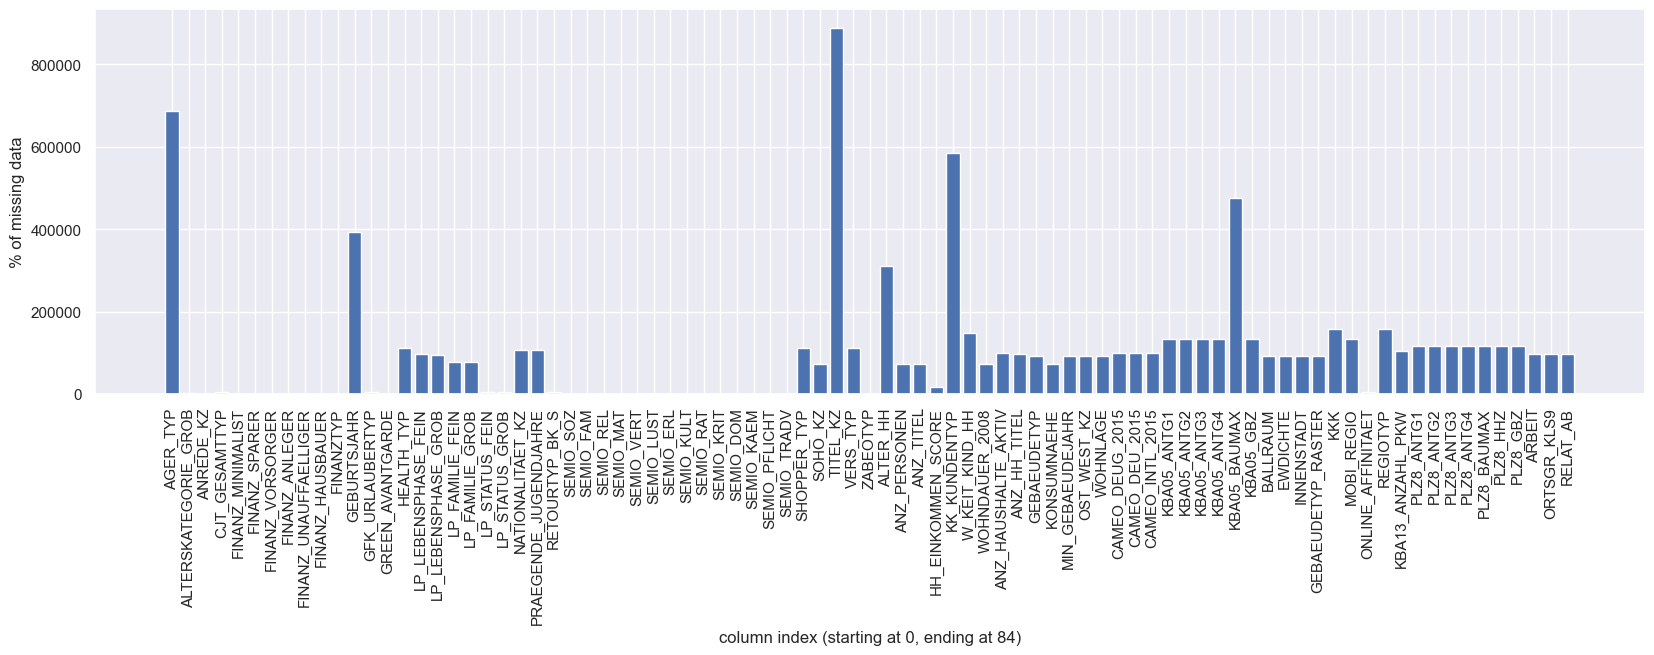

In [24]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.figure(figsize=(20, 5))
plt.bar(feat_info.index.values,[feat_info.loc[index, 'nan'] for index in feat_info.index.values])
plt.ylabel('% of missing data')
plt.xlabel('column index (starting at 0, ending at 84)')
plt.xticks(rotation=90)
plt.show()

**Optional Visualization: Checking how much data is missing with a heatmap**

**-------------------------------------------------------------------------------**

In [25]:
df_na = azdias.isnull().replace({False: 0, True: 1})

In [26]:
#number of features with missing values
len(feat_info[feat_info['nan']>0].index.values)

61

In [27]:
#Extracting only those columns from the dataset that have missing entries somewhere
df_na_actual = df_na[feat_info[feat_info['nan']>0].index.values].sort_index();
df_na_actual.head();

CPU times: user 8.48 s, sys: 1.17 s, total: 9.65 s
Wall time: 9.09 s


<AxesSubplot: >

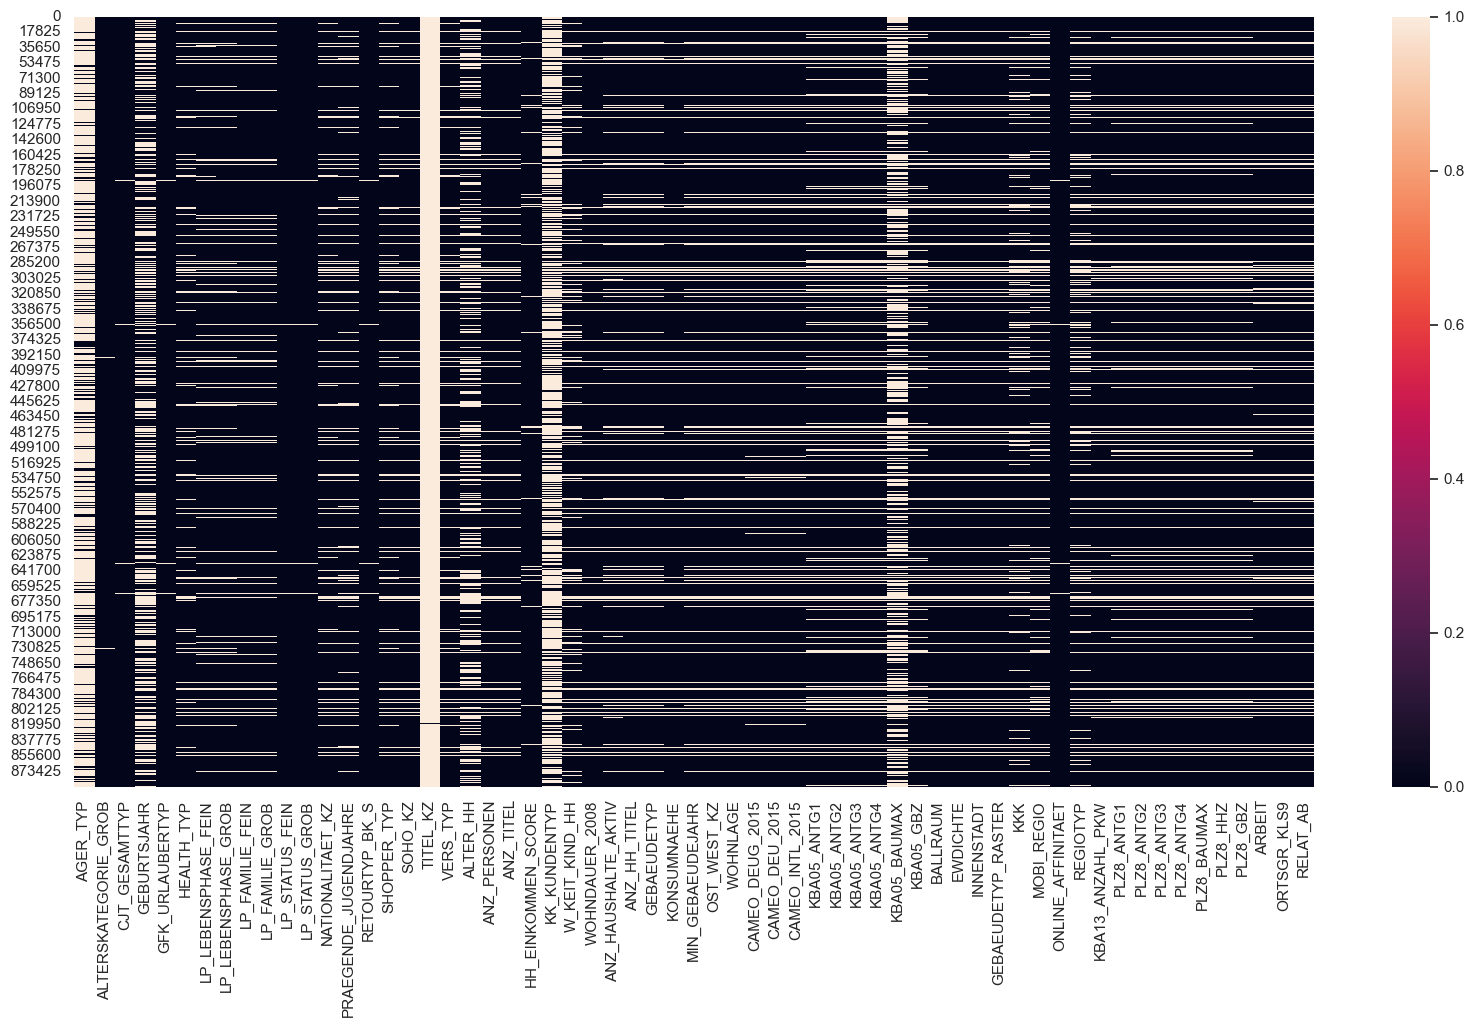

In [28]:
%%time
#Missing data heatmap. White indicates missing entries.

plt.figure(figsize = (20, 10))
sns.heatmap(df_na_actual)

**---------------------------------------------------------------------------------------**

In [29]:
# Investigate patterns in the amount of missing data in each column.

#Answer: The investigation has been done in several cells above. For further comments, see the discussion section

In [30]:
#Outlier_column
outlier_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [31]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_trim = azdias.drop(outlier_cols, axis=1)
feat_info_trim = feat_info.drop(outlier_cols, axis=0)
feat_info_trim["nan"] = azdias_trim.isna().sum()

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer:** Missing data exists in a float or object type column (nan values are float). We have a total of 8373929 missing entries overall, which amounts to an average of roughly 98517 missing entries per column. However, the distribution of missing entries is not uniform - certain outlier columns have an exceedingly large number of missing entries. From the heatplot, we can see the missing entries appearing as a white vertical streaks. There are 6 very prominent ones. From the labels, we can read off these columns as:

    1. 'AGER_TYP'
    2. 'GEBURTSJAHR'
    3. 'TITEL_KZ'
    4. 'ALTER_HH'
    5. 'KK_KUNDENTYP'
    6. 'KBA05_BAUMAX'

This is also confirmed by the histogram in the code cells above. The outlier columns have more than 310000 missing entries in each or at least more than 34% missing entries in each column. These columns are simply dropped and the data/feature dataframe have been accordingly updated.

------------

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [32]:
missing_row_data = azdias_trim.isna().sum(axis=1)

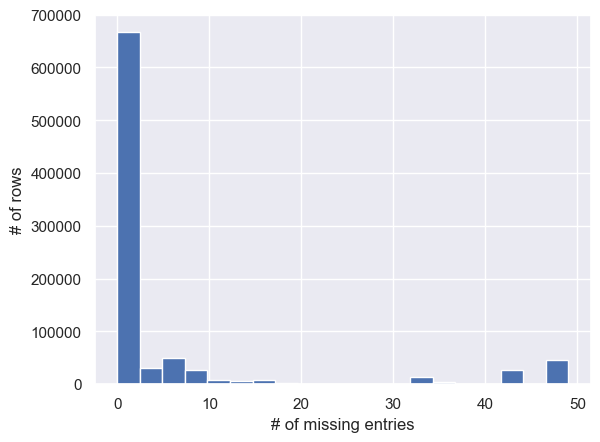

In [33]:
missing_row_data.hist(bins=20)
plt.xlabel("# of missing entries")
plt.ylabel("# of rows")
#plt.xlim(0, 10)
plt.show()

In [34]:
# How much data is missing in each row of the dataset?

#Answer: The cells above estimate the missing data with a histogram. For further comments, see discussion

#Avg number of missing values per row
azdias_trim.isna().sum().sum()/azdias_trim.shape[0]

5.649893797385833

In [35]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Revision: no_unknown is set equal to 9, otherwise we lose a lot of data!
no_unknown = 10
azdias_trim_A = azdias_trim[missing_row_data<=no_unknown]
azdias_trim_B = azdias_trim[missing_row_data>no_unknown]

In [36]:
#Suggested to continue analysis with data having few missing features, i.e. azdias_trim_A
feat_info_trim_A = feat_info_trim.copy()
feat_info_trim_A.loc[:,"nan"] = azdias_trim_A.isna().sum()

In [37]:
print(f"Length of dataset with less than equal to {no_unknown} missing features:", len(azdias_trim_A))
print(f"Length of dataset with more than {no_unknown} missing features:", len(azdias_trim_B))

Length of dataset with less than equal to 10 missing features: 780153
Length of dataset with more than 10 missing features: 111068


In [38]:
##### Columns in which data is not missing
zero_data_missing_cols = feat_info_trim_A[feat_info_trim_A['nan']==0].index.values
print("Number of columns in which data is not missing:", len(zero_data_missing_cols))
zero_data_missing_cols


Number of columns in which data is not missing: 33


array(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ',
       'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'WOHNDAUER_2008', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE'], dtype=object)

In [39]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#chosen_cols = [zero_data_missing_cols[x] for x in np.random.randint(len(zero_data_missing_cols), size = 5)]

randomly_chosen_cols = ['FINANZ_MINIMALIST', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ',  'ZABEOTYP']

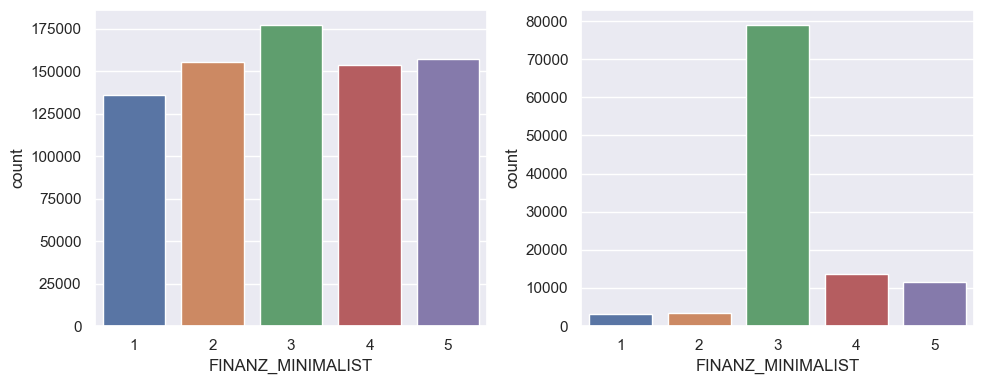

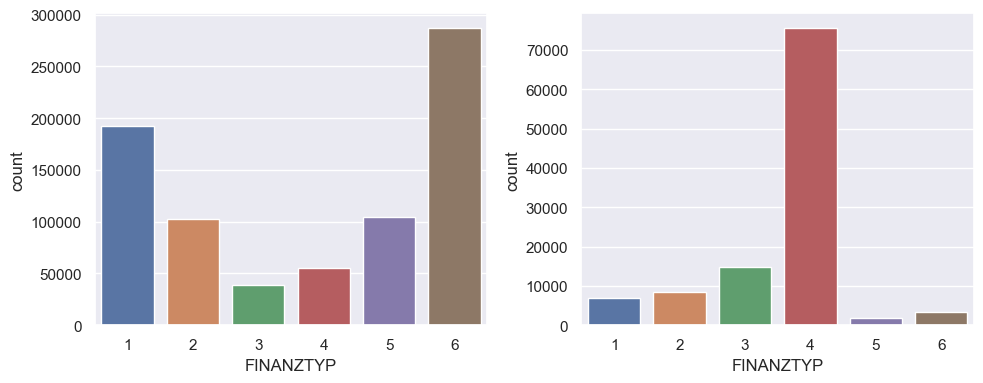

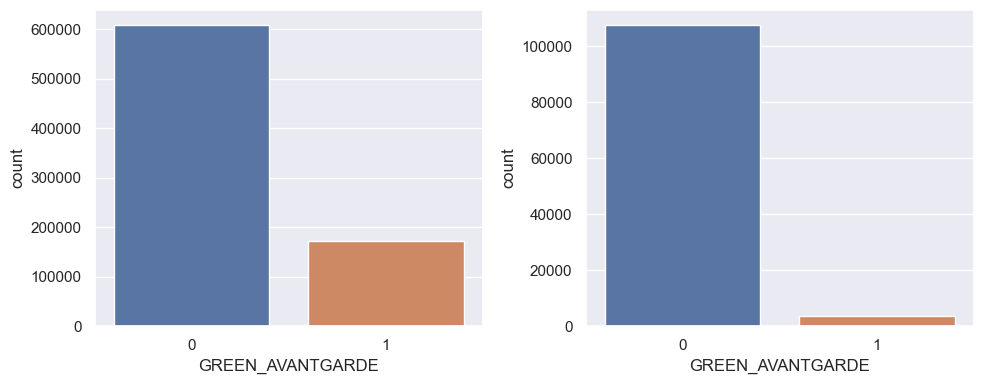

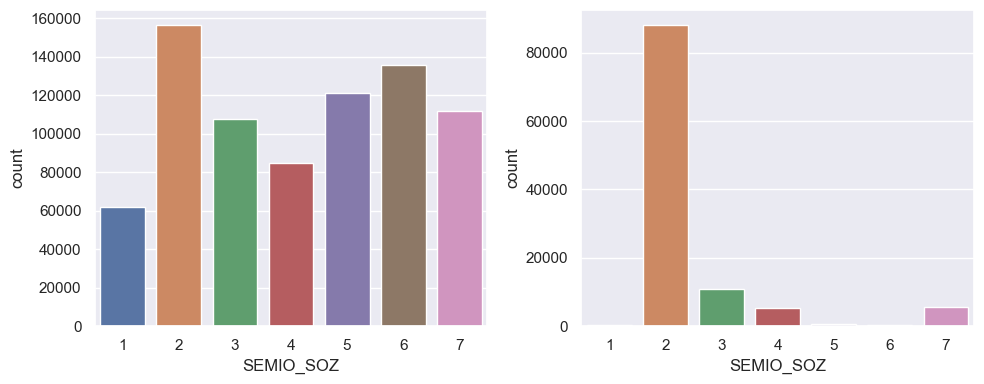

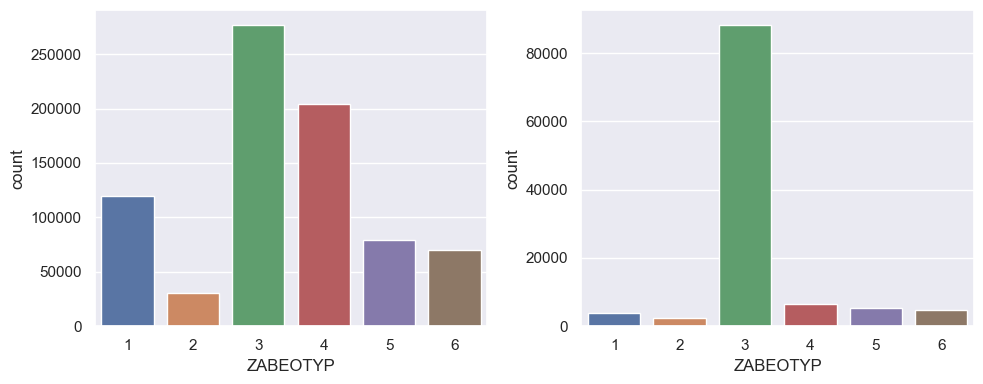

In [40]:
def comparison_plot(col):
    plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x = azdias_trim_A[col])
    plt.subplot(1, 2, 2)
    sns.countplot(x = azdias_trim_B[col])
    plt.tight_layout()
    plt.show()

for i in range(5):
    comparison_plot(randomly_chosen_cols[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer:** After dropping the columns, there are ~5.6 missing entries per row. If we drop all observations with missing entries, we lose a lot of data. So, we will choose 10 as the threshold - if the number of features missing in an observation is larger than 10, we drop it, otherwise it is retained.

From the comparison plots made on 5 randomly chosen columns, we do note that the two datasets created by the split are not qualitatively the same in general (e.g. 'SEMIO_SOZ', 'FINANZTYP' etc.).

----------------------------------------------------------------

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
# How many features are there of each data type?

feat_info_trim_A.groupby(['type', 'dtype']).count()

information_level  missing_or_unknown  nan
type        dtype                                              
categorical int64                    4                   4    4
            float64                 11                  11   11
            object                   3                   3    3
mixed       float64                  5                   5    5
            object                   1                   1    1
numeric     float64                  6                   6    6
ordinal     int64                   20                  20   20
            float64                 29                  29   29

In [42]:
#Just by type

feat_info_trim_A.groupby(['type']).count()

,information_level,missing_or_unknown,dtype,nan
type,,,,
categorical,18,18,18,18
mixed,6,6,6,6
numeric,6,6,6,6
ordinal,49,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
#List of categorical variables
categorical_cols_A = feat_info_trim_A[feat_info_trim_A['type']=='categorical'].index.values
categorical_cols_A

array(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [44]:
#Unique entries in columns with categorical data
unique_entries = [azdias_trim_A[x].dropna().unique() for x in categorical_cols_A]
unique_entries

[array([2, 1]),
 array([5., 3., 2., 4., 1., 6.]),
 array([1, 6, 5, 2, 4, 3]),
 array([10.,  1.,  5., 12.,  9.,  3.,  8., 11.,  4.,  7.,  2.,  6.]),
 array([0, 1]),
 array([ 5.,  1., 10.,  2.,  7., 11.,  8.,  4.,  6.,  9.,  3.]),
 array([3., 1., 5., 2., 4.]),
 array([ 2.,  3.,  9.,  4.,  1., 10.,  5.,  8.,  6.,  7.]),
 array([1., 2., 4., 5., 3.]),
 array([1., 3., 2.]),
 array([3., 2., 1., 0.]),
 array([1., 0.]),
 array([2., 1.]),
 array([5, 3, 4, 1, 6, 2]),
 array([8., 1., 3., 2., 6., 4., 5.]),
 array(['W', 'O'], dtype=object),
 array(['8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object),
 array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
        '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A',
        '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D',
        '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C'],
       dtype=object)]

In [45]:
#Number of unique entries in columns with categorical data
nunique_entries = [azdias_trim_A[x].dropna().nunique() for x in categorical_cols_A]
nunique_entries

[2, 6, 6, 12, 2, 11, 5, 10, 5, 3, 4, 2, 2, 6, 7, 2, 9, 44]

In [46]:
binary_categorical_cols_A = [categorical_cols_A[x] for x in np.where((np.array(nunique_entries)==2))][0]
binary_categorical_cols_A

array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP',
       'OST_WEST_KZ'], dtype=object)

Confirming with the data dictionary we confirm that the above features are indeed binary categorical features

In [47]:
object_cols_A = feat_info_trim_A[feat_info_trim_A['dtype']=='object'].index.values
object_cols_A

array(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015'], dtype=object)

In [48]:
#Categorical variables with string data

set(object_cols_A.tolist()).intersection(set(categorical_cols_A.tolist()))

{'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'OST_WEST_KZ'}

In [49]:
#Binary categorical variables with string data
set(object_cols_A.tolist()).intersection(set(binary_categorical_cols_A.tolist()))

{'OST_WEST_KZ'}

Conclusion: Only one binary categorical variable is encoded as a string. We will binary encode it. The other two will be dropped.


In [50]:
#Unique entries in binary categorical columns
PP.pprint({column: azdias_trim_A[column].unique() for column in binary_categorical_cols_A})

{'ANREDE_KZ': array([2, 1]),
 'GREEN_AVANTGARDE': array([0, 1]),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object),
 'SOHO_KZ': array([1., 0.]),
 'VERS_TYP': array([ 2.,  1., nan])}


In [51]:
#Multi-categorical columns
multi_categorical_cols_A = [x for x in categorical_cols_A if x not in binary_categorical_cols_A]

# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

print(f'Binary categorical variables are: {binary_categorical_cols_A}')
print('\nMulti-level categorical variables are:', multi_categorical_cols_A)

Binary categorical variables are: ['ANREDE_KZ' 'GREEN_AVANTGARDE' 'SOHO_KZ' 'VERS_TYP' 'OST_WEST_KZ']

Multi-level categorical variables are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


According to the suggestions we only need to re-encode categorical variables with string/object data type. So looking at columns with object data type below.

In [52]:
#Unique entries in an object dtype column
PP.pprint({column: azdias_trim_A[column].unique() for column in object_cols_A})

{'CAMEO_DEUG_2015': array(['8', '4', '2', '6', '1', '9', '5', '7', '3', nan], dtype=object),
 'CAMEO_DEU_2015': array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object),
 'CAMEO_INTL_2015': array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object)}


In [53]:
azdias_trim_A = pd.get_dummies(azdias_trim_A, columns=['OST_WEST_KZ'], drop_first = True)
feat_info_trim_A.rename(index={'OST_WEST_KZ': 'OST_WEST_KZ_W'}, inplace = True)

In [54]:
drop_categorical_cols = multi_categorical_cols_A
#Drop categorical columns
azdias_trim_A = azdias_trim_A.drop(drop_categorical_cols, axis=1)
#Update feature info
feat_info_trim_A = feat_info_trim_A.drop(drop_categorical_cols, axis=0)
feat_info_trim_A["nan"] = azdias_trim_A.isna().sum()

In [55]:
#Info about columns by type and dtype
feat_info_trim_A.groupby(['type','dtype']).count()

information_level  missing_or_unknown  nan
type        dtype                                              
categorical int64                    2                   2    2
            float64                  2                   2    2
            object                   1                   1    1
mixed       float64                  5                   5    5
            object                   1                   1    1
numeric     float64                  6                   6    6
ordinal     int64                   20                  20   20
            float64                 29                  29   29

In [56]:
#Info about columns by just type 
feat_info_trim_A.groupby(['type']).count()

,information_level,missing_or_unknown,dtype,nan
type,,,,
categorical,5,5,5,5
mixed,6,6,6,6
numeric,6,6,6,6
ordinal,49,49,49,49


In [57]:
print("Total NaN values at this point:", feat_info_trim_A["nan"].sum())
feat_info_trim_A["nan"]

Total NaN values at this point: 597547


ALTERSKATEGORIE_GROB    2625
ANREDE_KZ                  0
FINANZ_MINIMALIST          0
FINANZ_SPARER              0
FINANZ_VORSORGER           0
                        ... 
PLZ8_HHZ                8115
PLZ8_GBZ                8115
ARBEIT                  3999
ORTSGR_KLS9             3907
RELAT_AB                3999
Name: nan, Length: 66, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**: We find the following categorical features:

       ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Out of these we identify the binary categorical features:
       
       ['ANREDE_KZ' 'GREEN_AVANTGARDE' 'SOHO_KZ' 'VERS_TYP' 'OST_WEST_KZ']

And the multi-level categorical features:

       ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

We re-encoded one binary categorical feature using one-hot-encoding. The column 
is renamed 'OST_WEST_KZ_W' from 'OST_WEST_KZ' to indicate that the value is 1 if the
category is is 'W' and 0 otherwise.

For simplicity, the multi-level categorical features have all been dropped.

----------------------------------------------------------------

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [58]:
#List of mixed-type features
mixed_cols_A = feat_info_trim_A[feat_info_trim_A['type']=='mixed'].index.values
mixed_cols_A

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'PLZ8_BAUMAX'], dtype=object)

In [59]:
#Mixed variables with string data
set(object_cols_A.tolist()).intersection(set(mixed_cols_A.tolist()))

{'CAMEO_INTL_2015'}

In [60]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_trim_A["PRAEGENDE_JUGENDJAHRE"].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [61]:
feat_info_trim_A.loc["PRAEGENDE_JUGENDJAHRE", :]

information_level      person
type                    mixed
missing_or_unknown    [-1, 0]
dtype                 float64
nan                     26474
Name: PRAEGENDE_JUGENDJAHRE, dtype: object

In [62]:
dict_pj = {1.:[40, 1],
          2.:[40, 0],
           3.:[50, 1],
           4.: [50, 0],
           5.: [60, 1],
           6.: [60, 0],
           7.: [60, 0],
           8.: [70, 1],
           9.: [70, 0],
           10.: [80, 1],
           11.: [80, 0],
           12.: [80, 1],
           13.: [80, 0],
           14.: [90, 1],
           15.: [90, 0],
           np.nan: [np.nan, np.nan]
          }

In [63]:
azdias_trim_A[['PJ_DECADE', 'PJ_MOVEMENT']] = pd.DataFrame(
                                            azdias_trim_A["PRAEGENDE_JUGENDJAHRE"].map(dict_pj).values.tolist(), 
                                            columns = ['PJ_DECADE', 'PJ_MOVEMENT'],
                                            index = azdias_trim_A.index)

In [64]:
#Number of missing values at this stage of the analysis
azdias_trim_A.isna().sum().sum()

650495

### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [65]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias["CAMEO_INTL_2015"].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [66]:
azdias_trim_A.isna().sum()

ALTERSKATEGORIE_GROB     2625
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
                        ...  
ORTSGR_KLS9              3907
RELAT_AB                 3999
OST_WEST_KZ_W               0
PJ_DECADE               26474
PJ_MOVEMENT             26474
Length: 68, dtype: int64

In [67]:
#Creating new columns from CAMEO_INTL_2015

map_cameo1 = lambda x: int(x[0])
map_cameo2 = lambda x: int(x[1])


azdias_trim_A["CAMEO_INTL_2015_WEALTH"] = azdias_trim_A["CAMEO_INTL_2015"].map(map_cameo1, na_action='ignore')
azdias_trim_A["CAMEO_INTL_2015_LIFE_STAGE"] = azdias_trim_A["CAMEO_INTL_2015"].map(map_cameo2, na_action='ignore')

In [68]:
drop_mixed_cols = mixed_cols_A.tolist()

In [69]:
drop_mixed_cols

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [70]:
azdias_trim_A.isna().sum().sum()

657807

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

 **Answer**: 
 
 1. The feature "PRAEGENDE_JUGENDJAHRE" was re-encoded into 'PJ_DECADE' and 'PJ_MOVEMENT'. 
 
 2. The feature 'CAMEO_INTL_2015' was re-encoded into 'CAMEO_INTL_2015_WEALTH' and 'CAMEO_INTL_2015_LIFE_STAGE'.

 3. All the mixed-type features were dropped (including the original ones that were used to generate the new features).

----------------------------------------------------------------

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [71]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_trim_A = azdias_trim_A.drop(drop_mixed_cols, axis=1)

In [72]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

drop_columns = drop_categorical_cols+drop_mixed_cols
drop_columns #Created a list of columns that should be dropped

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [73]:
#Number of missing values at this stage of the analysis
azdias_trim_A.isna().sum().sum()

529094

In [74]:
azdias_trim_A.shape

(780153, 64)

In [75]:
len(drop_columns)

19

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as PP

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [77]:
outlier_cols = ['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

drop_columns = ['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

dict_pj = {1.:[40, 1],
          2.:[40, 0],
           3.:[50, 1],
           4.: [50, 0],
           5.: [60, 1],
           6.: [60, 0],
           7.: [60, 0],
           8.: [70, 1],
           9.: [70, 0],
           10.: [80, 1],
           11.: [80, 0],
           12.: [80, 1],
           13.: [80, 0],
           14.: [90, 1],
           15.: [90, 0],
           np.nan: [np.nan, np.nan]
          }

In [78]:
def correct_type(x, datatype):
    if datatype!=np.dtype('object'):
        if x.lstrip('-').isdigit():
            #print("Numeric type")
            if datatype==np.dtype('int64'):
                #print("Integer type")
                return int(x)
            else:
                #print("Float type")
                return float(x)
    else:
        #print("String type")
        if x.lstrip('-').isdigit():
            return float(x)
        else:
            return x

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    cols = list(feat_info["attribute"])
    feat_info = feat_info.set_axis(cols, axis='index')
    feat_info['dtype'] = df.dtypes
    feat_info = feat_info.drop(["attribute"], axis=1)


    feat_info.loc[:, 'missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    feat_info.loc[:, 'missing_or_unknown'] = feat_info.apply(lambda row: [correct_type(y, row['dtype']) 
                                                                          for y in row['missing_or_unknown']], 
                                                             axis=1)
    
    for index in feat_info.index:
        df[index].replace(feat_info.loc[index, 'missing_or_unknown'], np.nan, inplace = True)
    
    # remove selected columns and rows, ...
    
    df = df.drop(outlier_cols, axis=1) #Remove outlier columns
    no_unknown = 10
    missing_row_data = df.isna().sum(axis=1)
    df = df[missing_row_data<=no_unknown]
    
    
    # select, re-encode, and engineer column values.
    
    #'OST_WEST_KZ' binary encoded and renamed to 'OST_WEST_KZ_W'
    
    df = pd.get_dummies(df, columns=['OST_WEST_KZ'], drop_first = True)
    
    #PRAEGENDE_JUGENJAHRE DATA RE-ENCODED
    df[['PJ_DECADE', 'PJ_MOVEMENT']] = pd.DataFrame(
                                            df["PRAEGENDE_JUGENDJAHRE"].map(dict_pj).values.tolist(), 
                                            columns = ['PJ_DECADE', 'PJ_MOVEMENT'],
                                            index = df.index)
    
    
    #CAMEO_INTL_2015 DATA RE-ENCODED
    
    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].map(lambda x: int(x[0]), na_action='ignore')
    df["CAMEO_INTL_2015_LIFE_STAGE"] = df["CAMEO_INTL_2015"].map(lambda x: int(x[1]), na_action='ignore')
    
    #Drop the other categorical+mixed features columns
    
    df = df.drop(drop_columns, axis=1)
    
    # Return the cleaned dataframe.
    return df    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [80]:
%%time
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_clean = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';'))

CPU times: user 2.83 s, sys: 703 ms, total: 3.53 s
Wall time: 3.55 s


In [81]:
assert azdias_clean.shape[0] == azdias_trim_A.shape[0], "clean_data function is not working properly, rows mismatch"
assert azdias_clean.shape[1] == azdias_trim_A.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


In [82]:
azdias_clean.shape

(780153, 64)

In [83]:
azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS

#### Imputation Step

In [84]:
#WARNING: RUN ONLY ONCE. Imputation done and the old name is retained

from sklearn.impute import SimpleImputer

simputer = SimpleImputer(missing_values=np.nan)
azdias_clean = pd.DataFrame(simputer.fit_transform(azdias_clean), columns = azdias_clean.columns.values)

In [85]:
#For later we are counting the observations that we discarded during the clean up process
azdias_missing = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';').shape[0] - azdias_clean.shape[0] #Observations with missing entries
print("Azdias_high_missing:", azdias_missing)

Azdias_high_missing: 111068


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**Answer**: The missing entries were imputed via the SimpleImputer fit_transform function. We use StandardScaler for the feature scaling part.

----------------------------------------------------------------

In [86]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_clean), columns = azdias_clean.columns,
                             index = azdias_clean.index)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [87]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

def do_pca(n_comp, X):
    pca = PCA(n_components = n_comp)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

pca, X_pca = do_pca(64, np.asarray(azdias_scaled))

<BarContainer object of 64 artists>

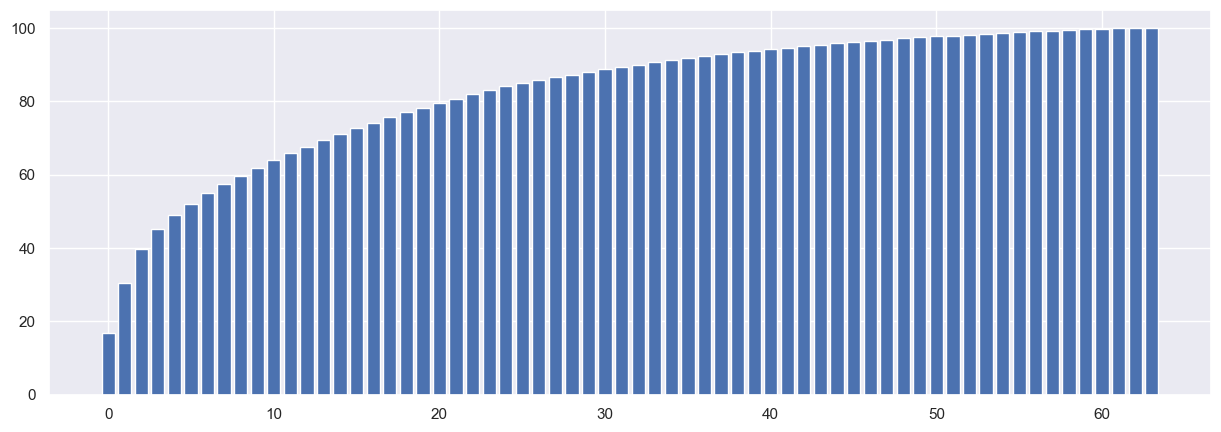

In [88]:
# Investigate the variance accounted for by each principal component.
variances = pca.explained_variance_ratio_*100
cumulative = np.cumsum(variances)
sns.set()
plt.figure(figsize = (15, 5))
plt.bar(np.arange(azdias_scaled.shape[1]), cumulative)

(array([38., 12.,  7.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([5.35183922e-03, 8.52011775e-01, 1.69867171e+00, 2.54533165e+00,
        3.39199158e+00, 4.23865152e+00, 5.08531145e+00, 5.93197139e+00,
        6.77863133e+00, 7.62529126e+00, 8.47195120e+00, 9.31861113e+00,
        1.01652711e+01, 1.10119310e+01, 1.18585909e+01, 1.27052509e+01,
        1.35519108e+01, 1.43985707e+01, 1.52452307e+01, 1.60918906e+01,
        1.69385506e+01]),
 <BarContainer object of 20 artists>)

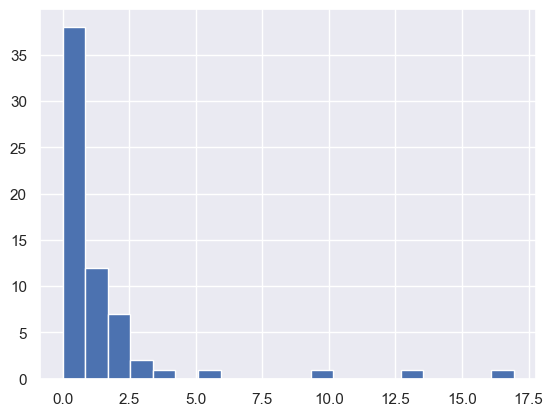

In [89]:
plt.hist(variances, bins=20)

In [90]:
cumulative[25] #We reached ~85% reconstruction with 26 PCA components

85.0624185240084

In [91]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_selected, X_pca_selected = do_pca(26, np.asarray(azdias_scaled))

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Answer**: We achieve nearly 85% reconstruction of the original dataset using 26 PCA features. So we will henceforth reduce the number of principal feature dimensions to 26.

----------------------------------------------------------------

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

Top 10+ve weights for new PCA feature 0: 
      weights                    name
52  0.226916              PLZ8_ANTG3
53  0.220064              PLZ8_ANTG4
62  0.207770  CAMEO_INTL_2015_WEALTH
29  0.204409      HH_EINKOMMEN_SCORE
57  0.197644             ORTSGR_KLS9
42  0.195882                EWDICHTE
7   0.163222        FINANZ_HAUSBAUER
51  0.154399              PLZ8_ANTG2
39  0.153201             KBA05_ANTG4
3   0.144051           FINANZ_SPARER

Top 10-ve PCA weights for new PCA feature 0: 
      weights                        name
63 -0.125266  CAMEO_INTL_2015_LIFE_STAGE
41 -0.127402                    BALLRAUM
43 -0.164959                  INNENSTADT
55 -0.168027                    PLZ8_GBZ
34 -0.168210                 KONSUMNAEHE
40 -0.217418                   KBA05_GBZ
2  -0.218579           FINANZ_MINIMALIST
36 -0.225873                 KBA05_ANTG1
50 -0.226532                  PLZ8_ANTG1
46 -0.242369                  MOBI_REGIO


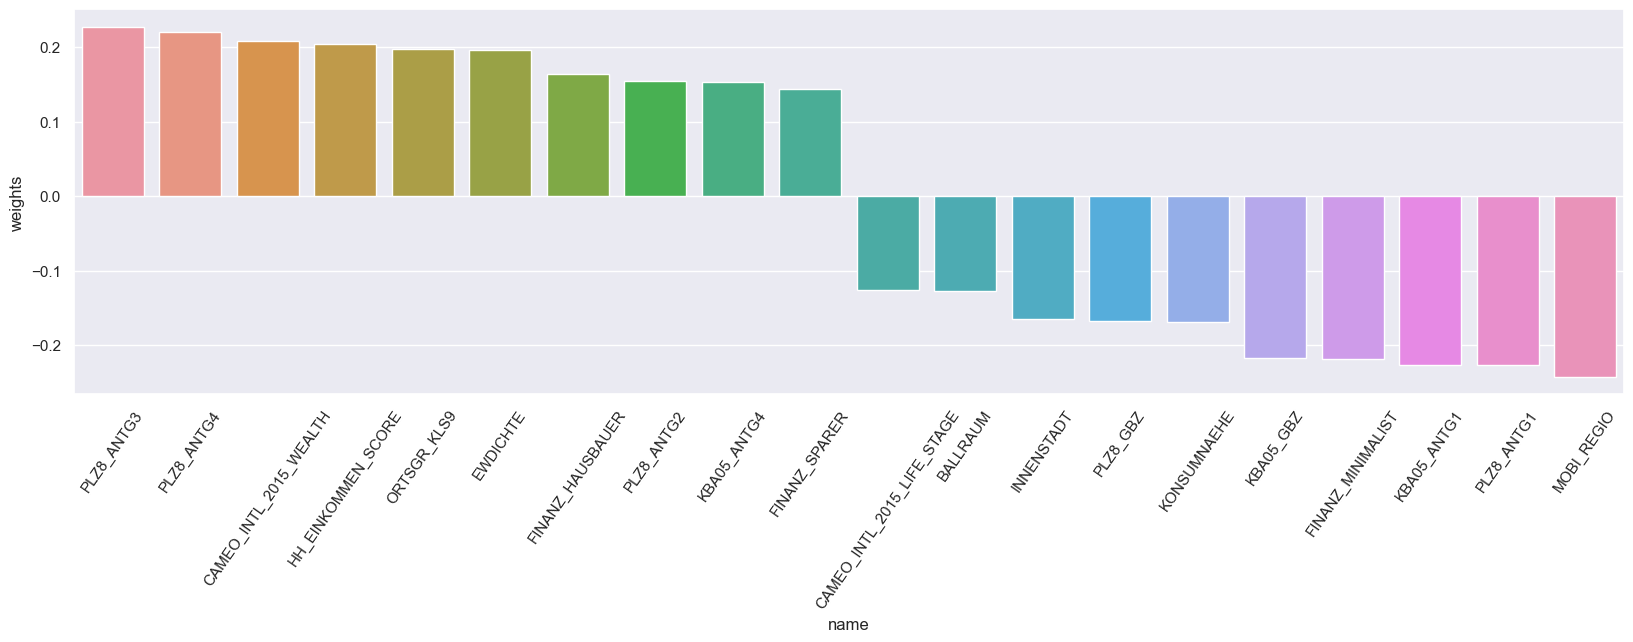

In [92]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_weights(pca, index):
    weights = pca.components_[index]
    cols = azdias_clean.columns.values
    df = pd.DataFrame(list(zip(weights, cols)), columns = ['weights', 'name'])
    return df.sort_values(by = 'weights', ascending = False)


i=0
print("Top 10+ve weights for new PCA feature {}: \n".format(i), get_weights(pca, i)[:10]) 
print("\nTop 10-ve PCA weights for new PCA feature {}: \n".format(i), get_weights(pca, i)[-10:]) 
series_weights = pd.concat([get_weights(pca, i)[:10], get_weights(pca, i)[-10:]])
plt.figure(figsize=(20, 5))
sns.barplot(data=series_weights, x = "name", y="weights")
plt.xticks(rotation=55)
plt.show()

Top 10+ve weights for new PCA feature 1: 
      weights                  name
0   0.260661  ALTERSKATEGORIE_GROB
4   0.233291      FINANZ_VORSORGER
17  0.230849             SEMIO_ERL
16  0.183091            SEMIO_LUST
10  0.164124        RETOURTYP_BK_S
30  0.118493        W_KEIT_KIND_HH
20  0.116364            SEMIO_KRIT
7   0.114645      FINANZ_HAUSBAUER
22  0.111438            SEMIO_KAEM
52  0.090983            PLZ8_ANTG3

Top 10-ve PCA weights for new PCA feature 1: 
      weights                   name
19 -0.171583              SEMIO_RAT
12 -0.183658              SEMIO_FAM
5  -0.205319         FINANZ_ANLEGER
18 -0.220275             SEMIO_KULT
6  -0.227328  FINANZ_UNAUFFAELLIGER
23 -0.229590          SEMIO_PFLICHT
24 -0.231729            SEMIO_TRADV
3  -0.236306          FINANZ_SPARER
60 -0.251596              PJ_DECADE
13 -0.255824              SEMIO_REL


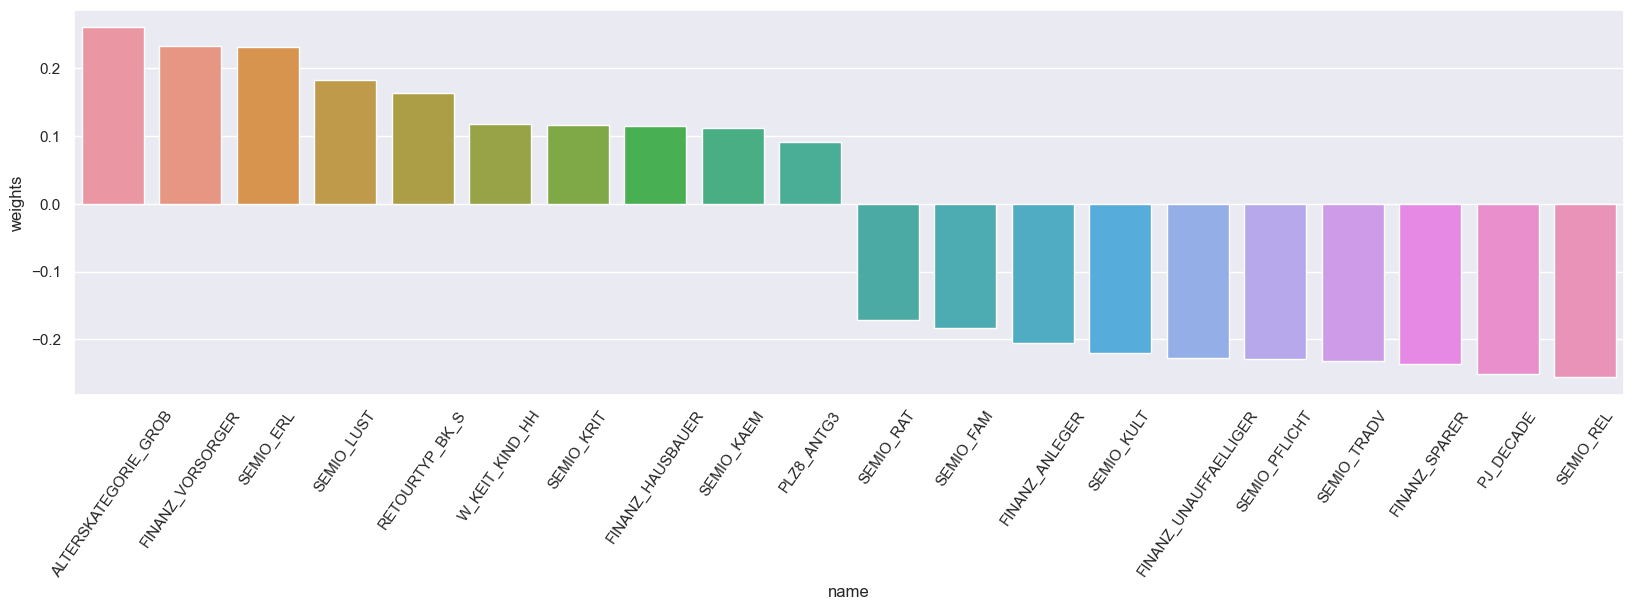

In [93]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.


i=1
print("Top 10+ve weights for new PCA feature {}: \n".format(i), get_weights(pca, i)[:10]) 
print("\nTop 10-ve PCA weights for new PCA feature {}: \n".format(i), get_weights(pca, i)[-10:]) 
series_weights = pd.concat([get_weights(pca, i)[:10], get_weights(pca, i)[-10:]])
plt.figure(figsize=(20, 5))
sns.barplot(data=series_weights, x = "name", y="weights")
plt.xticks(rotation=55)
plt.show()

Top 10+ve weights for new PCA feature 2: 
      weights                  name
15  0.346302            SEMIO_VERT
11  0.263440             SEMIO_SOZ
12  0.250183             SEMIO_FAM
18  0.234318            SEMIO_KULT
2   0.156292     FINANZ_MINIMALIST
10  0.108787        RETOURTYP_BK_S
4   0.100357      FINANZ_VORSORGER
30  0.090580        W_KEIT_KIND_HH
0   0.078690  ALTERSKATEGORIE_GROB
13  0.070223             SEMIO_REL

Top 10-ve PCA weights for new PCA feature 2: 
      weights                   name
6  -0.098763  FINANZ_UNAUFFAELLIGER
3  -0.105482          FINANZ_SPARER
60 -0.107106              PJ_DECADE
17 -0.175422              SEMIO_ERL
5  -0.188816         FINANZ_ANLEGER
19 -0.217225              SEMIO_RAT
20 -0.274133             SEMIO_KRIT
21 -0.313967              SEMIO_DOM
22 -0.337493             SEMIO_KAEM
1  -0.369074              ANREDE_KZ


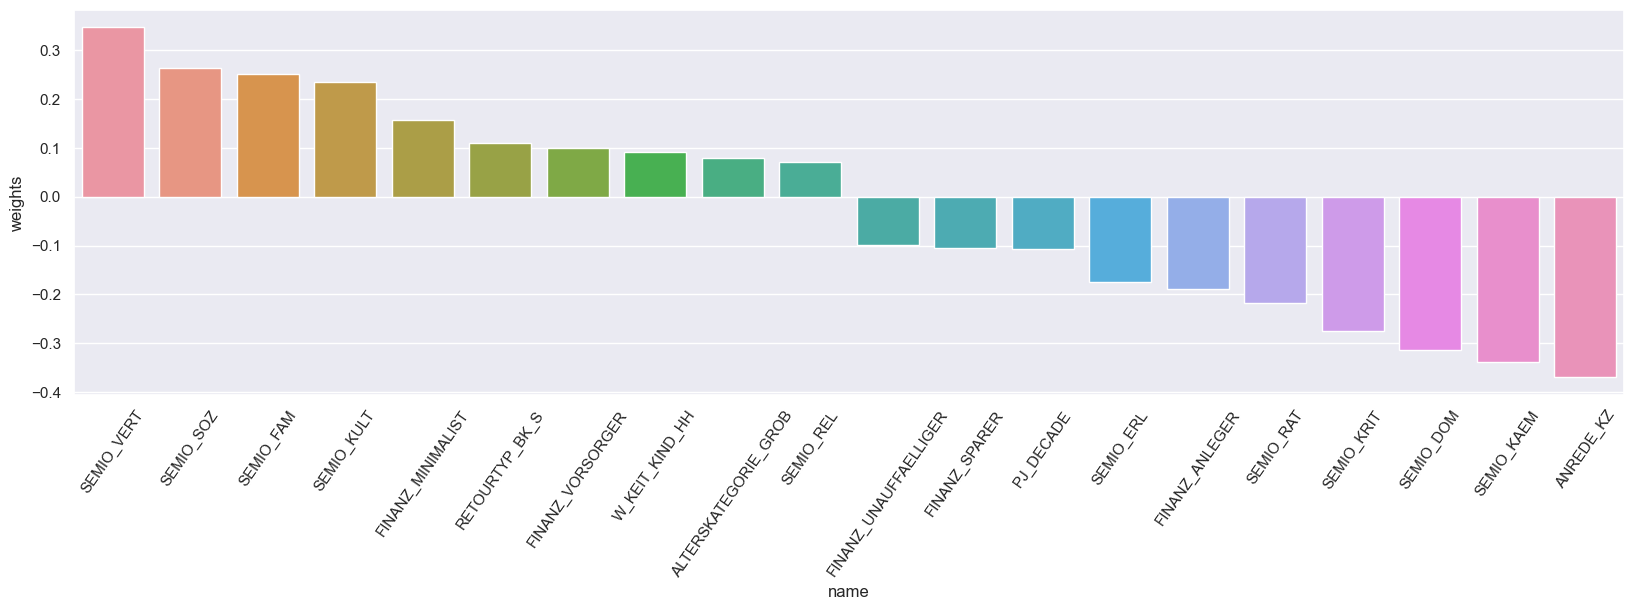

In [94]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

i=2
print("Top 10+ve weights for new PCA feature {}: \n".format(i), get_weights(pca, i)[:10]) 
print("\nTop 10-ve PCA weights for new PCA feature {}: \n".format(i), get_weights(pca, i)[-10:]) 
series_weights = pd.concat([get_weights(pca, i)[:10], get_weights(pca, i)[-10:]])
plt.figure(figsize=(20, 5))
sns.barplot(data=series_weights, x = "name", y="weights")
plt.xticks(rotation=55)
plt.show()

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


**Answer**:

With the code cells above we can find the top 10 contributors to the first few principal components (with both positive and negative signs).


The PCA components in general are a complex mix of the original features and cannot typically be reduced to a few features in the original space. The magnitude of the component is what makes it important (not the sign itself as that could simply be reversed by reversing the sign of the numeric labels or by reversing the ordering within the feature space). From the lists shown above (which has the weight of the principal components), we see that components 0 and 1 are quite complex and depend on a complex mix of many features (the higher the weight in magnitude the more relevant that feature gets). For component 2 on the other hand, the weights reduce pretty fast and we can see that it can be largely be interpreted as a combination of say features carrying top 10 positive and negative weights.


----------------------------------------------------------------

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [95]:
# Over a number of different cluster counts...


# run k-means clustering on the data and...
    
    
# compute the average within-cluster distances.

from sklearn.cluster import KMeans
    
num_clusters = np.arange(1, 30)
scores_list = []
for j in num_clusters:
    kmeans = KMeans(n_clusters=j, init='k-means++', random_state=42)
    kmeans.fit(X_pca_selected)
    scores_list.append(kmeans.score(X_pca_selected))

(0.0, 30.0)

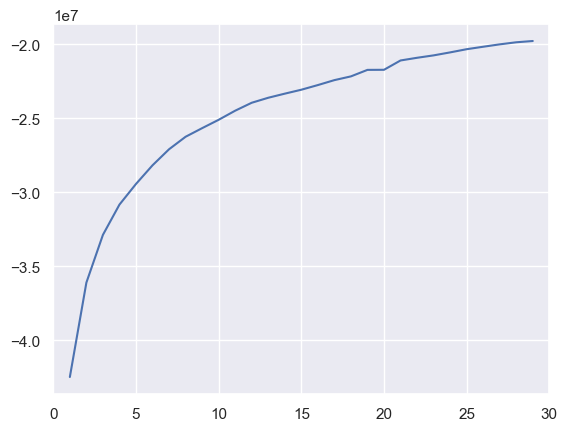

In [96]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(num_clusters, scores_list)
plt.xlim(0, 30)

(8.0, 16.0)

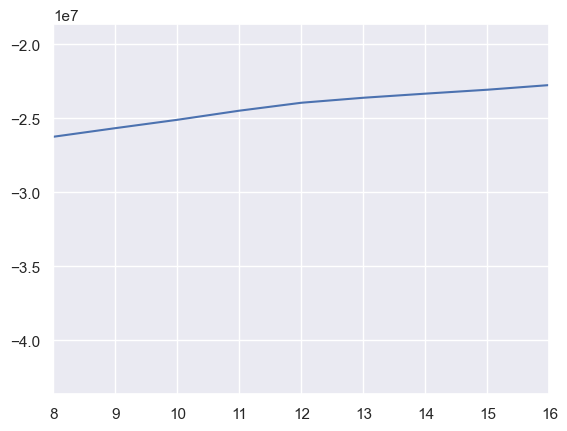

In [110]:
plt.plot(num_clusters, scores_list)
plt.xlim(8, 16)

In [111]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=12, init = 'k-means++', random_state = 42)
kmeans.fit(X_pca_selected)
gen_pop_pred = kmeans.predict(X_pca_selected)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Answer:** We have decided to use 12 clusters. There is no clear cut unique elbow in the figure and the score is improving quite smoothly with the number of clusters. So we choose one elbow that is not too far off from the best score among the various values of `n_clusters` that were tried out.

----------------------------------------------------------------

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [112]:
# Load in the customer demographics data.
customers_data = clean_data(pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';'))

#### Imputation Step

In [113]:
#WARNING: RUN ONLY ONCE. Imputation done and the old name is retained

customers_data = pd.DataFrame(simputer.transform(customers_data), columns = azdias_clean.columns.values)

In [114]:
#For later we are counting the observations that we discarded during the cleaning up process
customers_missing = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';').shape[0] - customers_data.shape[0] #Observations with missing entries
print("Customers_missing:", customers_missing)

Customers_missing: 52584


In [115]:
customers_data.shape

(139068, 64)

In [116]:
customers_data.columns #check that the column from pd.get_dummies is exactly the same as the general population dataset

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS

In [117]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_data_scaled = pd.DataFrame(scaler.transform(customers_data), 
                                     columns = customers_data.columns, 
                                     index = customers_data.index)

X_customer = np.asarray(customers_data_scaled)
customers_pred = kmeans.predict(pca_selected.transform(X_customer))


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

<BarContainer object of 13 artists>

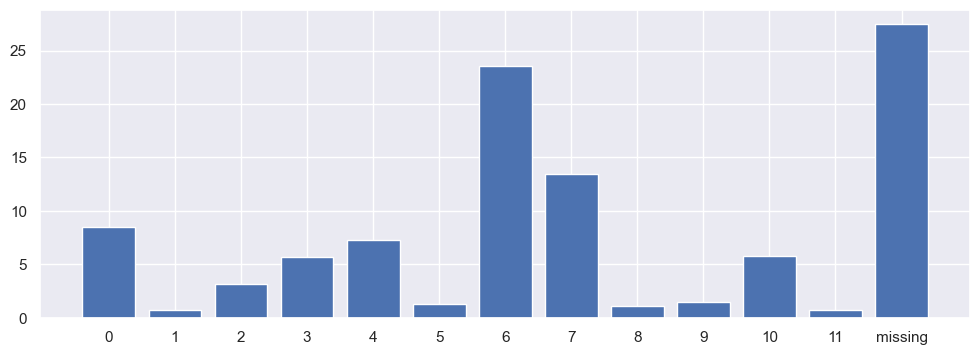

In [118]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customers_series = pd.Series(customers_pred)
customers_percent = customers_series.value_counts().sort_index()
customers_percent = customers_percent.rename(lambda x: str(x))

#Add data with missing entries as a separate cluster
customers_percent.loc["missing"] = int(customers_missing)

customers_percent = customers_percent/customers_percent.values.sum()*100
plt.figure(figsize = (12, 4))
plt.bar(customers_percent.index.values, customers_percent.values)


<BarContainer object of 13 artists>

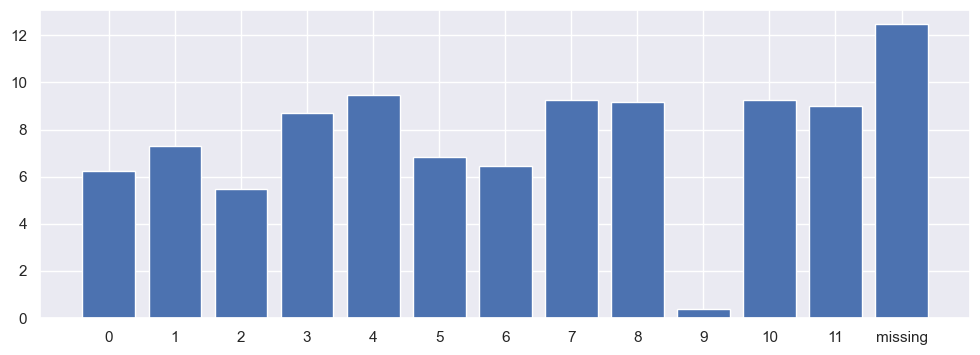

In [119]:
gen_pop_series = pd.Series(gen_pop_pred)
gen_pop_percent = gen_pop_series.value_counts().sort_index()
gen_pop_percent = gen_pop_percent.rename(lambda x: str(x))

#Add data with missing entries as a separate cluster
gen_pop_percent["missing"] = azdias_missing

gen_pop_percent = gen_pop_percent/gen_pop_percent.sum()*100
plt.figure(figsize = (12, 4))
plt.bar(gen_pop_percent.index.values, gen_pop_percent.values)

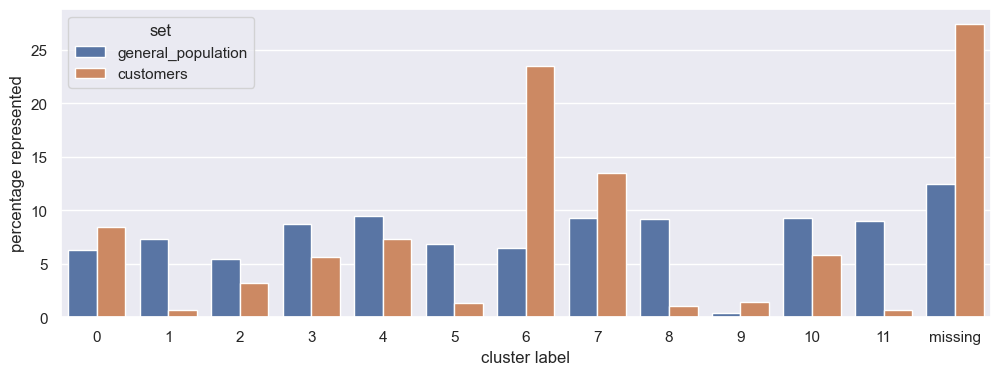

In [120]:
df_pop = pd.DataFrame(zip(gen_pop_percent.index.values, gen_pop_percent.values, ["general_population" for i in range(customers_percent.shape[0])]), columns=["cluster", "percent", "set"])
df_cust = pd.DataFrame(zip(customers_percent.index.values, customers_percent.values, ["customers" for i in range(customers_percent.shape[0])]), columns=["cluster", "percent", "set"])
percentage_df = pd.concat([df_pop, df_cust])

plt.figure(figsize = (12, 4))
sns.barplot(data=percentage_df, x = "cluster", y = "percent", hue = "set")
plt.xlabel("cluster label")
plt.ylabel("percentage represented")
plt.show()

In [121]:
#Getting cluster centers in the original feature space

cluster_centers = kmeans.cluster_centers_ #In the reduced & transformed feature space

cluster_centers_original = pd.DataFrame(scaler.inverse_transform(pca_selected.inverse_transform(cluster_centers)), columns = azdias_clean.columns) #In the original feature space

cluster_centers_original

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,PJ_DECADE,PJ_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,3.397161,1.947828,4.107444,1.722022,4.115668,2.224923,2.274210,2.363087,0.984667,2.137813,...,3.690710,3.900635,2.958646,5.317471,2.858268,0.902168,67.206144,0.012669,2.027137,3.606809
1,1.878574,0.960115,1.898621,4.343431,2.140825,3.550828,3.741989,3.621233,0.119496,2.374388,...,3.755207,2.665310,3.696147,6.986526,3.741016,0.696378,86.496184,0.872448,4.402884,1.965593
2,3.362898,1.602663,2.476177,2.181875,4.008454,2.083661,1.715035,4.282866,0.045554,2.199148,...,3.749052,2.210783,3.644464,7.592436,3.609385,0.615517,66.065598,0.937074,4.572662,2.430169
3,3.499125,1.920578,3.659304,1.832818,4.110710,2.869138,1.988461,2.853080,0.003714,2.100647,...,3.301822,3.845649,2.629181,3.246010,2.312152,0.786919,66.336283,0.991513,2.540078,3.284813
4,3.331087,1.049413,3.420647,1.957697,4.189359,1.636985,1.768167,3.447424,0.071062,2.381179,...,3.753614,3.018317,3.605162,6.321875,3.698413,0.768905,64.793191,0.921997,4.197061,2.414804
5,1.840695,0.960850,3.003199,4.102297,2.188412,3.888755,4.026604,2.322406,0.293748,2.176166,...,3.556474,3.899773,2.795774,4.035793,2.569920,0.834349,87.027959,0.700500,2.502259,3.202973
6,3.281111,1.067387,4.838739,1.632114,4.166100,1.510583,2.169243,1.871475,0.984517,2.055831,...,3.691961,3.895877,3.018562,5.327465,2.916829,0.896467,66.210388,0.015437,2.103561,3.600034
7,3.289227,1.096898,4.456888,1.755740,4.159796,2.194277,1.892473,2.161046,0.009848,2.348432,...,3.290164,3.847943,2.628044,3.272154,2.322403,0.812465,66.433363,0.990820,2.513774,3.289607
8,1.763632,1.979852,2.312672,3.983828,2.268470,4.429485,3.874833,2.863476,0.178768,2.231977,...,3.544175,3.945010,2.752855,3.927069,2.504589,0.851074,85.750508,0.808959,2.516740,3.209680
9,3.099369,1.451759,3.508987,2.112116,3.847976,2.182032,2.348731,3.201600,0.661992,2.115616,...,3.752712,3.356786,3.149934,5.875923,3.145919,0.780600,67.351621,0.322298,2.761811,3.252772


In [122]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_centers_original.loc[[6, 9]]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,PJ_DECADE,PJ_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
6,3.281111,1.067387,4.838739,1.632114,4.166100,1.510583,2.169243,1.871475,0.984517,2.055831,...,3.691961,3.895877,3.018562,5.327465,2.916829,0.896467,66.210388,0.015437,2.103561,3.600034
9,3.099369,1.451759,3.508987,2.112116,3.847976,2.182032,2.348731,3.201600,0.661992,2.115616,...,3.752712,3.356786,3.149934,5.875923,3.145919,0.780600,67.351621,0.322298,2.761811,3.252772


In [123]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_centers_original.loc[[1, 5, 8, 11]]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,PJ_DECADE,PJ_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.878574,0.960115,1.898621,4.343431,2.140825,3.550828,3.741989,3.621233,0.119496,2.374388,...,3.755207,2.665310,3.696147,6.986526,3.741016,0.696378,86.496184,0.872448,4.402884,1.965593
5,1.840695,0.960850,3.003199,4.102297,2.188412,3.888755,4.026604,2.322406,0.293748,2.176166,...,3.556474,3.899773,2.795774,4.035793,2.569920,0.834349,87.027959,0.700500,2.502259,3.202973
8,1.763632,1.979852,2.312672,3.983828,2.268470,4.429485,3.874833,2.863476,0.178768,2.231977,...,3.544175,3.945010,2.752855,3.927069,2.504589,0.851074,85.750508,0.808959,2.516740,3.209680
11,1.666146,2.008902,1.153636,4.283796,2.210365,4.153350,3.717004,4.214115,0.044618,2.198637,...,3.754956,2.745035,3.665449,6.937119,3.743017,0.745760,85.698146,0.941695,4.343556,2.069216


###### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Answer:**

Customers in cluster 6 are quite popular with the mail-order company, both in the relative and the absolute sense. These are people in the age range ~45-60 years old, males, either not too interested in finance or possibly investors with buildings located in West Germany. They have prosperous households and are either mature couples or have school going kids. These are people who had their formative years in the 60s (from PJ_DECADE). Customers in cluster 9 generally have similar attributes except that this time they could be either males or females.


Clusters 1, 5, 8, 11 are unpopular with the mail order company. These are people with their formative years (PJ_Decade) in the 80s. Clusters 1, 5 have males and 8, 11 have females. Clusters 5, 8 have people who are prosperous/comfortable financially with school going children, while 1, 11 have less affluent households and are typically young couples with children.

----------------------------------------------------------------


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

References used for pandas functions:
1.  geeksforgeeks
2.  pandas 
3.  tutorialpoint 
4.  stackoverflow 

References for PCA:
1. [Data Science Book](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
2. [Example of PCA](https://dzone.com/articles/understanding-what-is-principal-component-analysis)

References for Imputation:

1. [Sklearn documentation](https://scikit-learn.org/stable/modules/impute.html#impute)
2. [Analytics India Magazine](https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/)
3. [CodeUnderscored](https://www.codeunderscored.com/how-to-handle-missing-data-using-simpleimputer-of-scikit-learn/)